# COGS 108 - Final Project 

# Overview

This project analyzes the relationship between park quality and the socioeconomic status of the neighborhood surrounding that park. This analysis compares park quality in the form of yelp reviews to information about the parks and socioeconomic data based on zip codes. The analysis suggests that there is no relationship between socioeconomic factors and park quality.

# Name & GitHub

- Name: Nathan Tang
- GitHub Username: nltang

# Research Question

What features of parks and their surrounding are best predict the rating of a park? Is park quality solely related to factors that describe a park or is quality also affected by the characteristics that describe its zip code?

## Background and Prior Work

Parks are locations designed for outdoor activities. There have previously been studies about the relationship between park quality and socioeconomics, including a study in Los Angeles comparing the provision and quality of park facilities between inner city and suburban parks using the satisfaction of children [1]. Tools such as QUINPY are also being designed to help cities easily assess park quality and determine their cultural inclusiveness in order to better distribute funds. Another factor that may be related to park quality is location. Since many parks are located in places that leverage the wonders of nature, there may be a spatial autocorrelation with parks.

One way to easily and publically view park quality is with Yelp reviews. As Yelp has grown more popular, studies have found that people are finding Yelp reviews credible, so they may serve as an indicator of park quality [3].

References (include links):
- 1)Loukaitou-Sideris, Anastasia, and Orit Stieglitz. "Children in Los Angeles parks: a study of equity, quality and children's satisfaction with neighbourhood parks." Town planning review 73.4 (2002): 467-489.
    https://www.liverpooluniversitypress.co.uk/journals/article/49154/
- 2)Rigolon, Alessandro, and Jeremy Németh. "A QUality INdex of Parks for Youth (QUINPY): Evaluating urban parks through geographic information systems." Environment and Planning B: Urban Analytics and City Science 45.2 (2018): 275-294.
    https://journals.sagepub.com/doi/full/10.1177/0265813516672212?casa_token=EyTrgmC7cDgAAAAA%3AA1WHsA0IM29KxGbgGc5Ft8TuJ0WSCFeHdIm4xi_lkVOw7ey6kowxec5a-xIBvOeFl3fgT2yx0H8
- 3)Lim, Young-shin, and Brandon Van Der Heide. "Evaluating the wisdom of strangers: The perceived credibility of online consumer reviews on Yelp." Journal of Computer-Mediated Communication 20.1 (2015): 67-82.
    https://academic.oup.com/jcmc/article/20/1/67/4067556

# Hypothesis


Since park quality increases land value and the cost of living, median income should best correlate with park quality measured in Yelp reviews. This means that median income will be the strongest predictor of park quality.

# Dataset(s)

- Dataset Name: yelp_parks_sd.csv
- Link to the dataset: Provided dataset
- Number of observations: 833

Dataset that contains yelp information about the parks. Observations have data such as the park name, 

- Dataset Name: parks_datasd.geojson
- Link to the dataset: Provided dataset
- Number of observations: 2769

Dataset that contains yelp information about the parks. Observations have data such as the park name, 

- Dataset Name: SD_inc_2010_zip.csv
- Link to the dataset: https://datasurfer.sandag.org/
- Number of observations: 1238

Dataset that contains income information for zip codes in San Diego. Each zip code has the number of households in each bracket and the median income.

- Dataset Name: SD_pov_2010_zip.csv
- Link to the dataset:https://datasurfer.sandag.org/
- Number of observations: 339

Dataset that contains poverty rate information for zip codes in San Diego. Each zip code has observations with the total number of households, the number of households below poverty, and the number of households above poverty.

- Dataset Name: SD_race_2010_zip.csv
- Link to the dataset: https://datasurfer.sandag.org/
- Number of observations: 860

Dataset that contains information about the number of people who identify as a set of races in each zip code of San Diego. Each observation is the number of people that are a certain race in a specific zip code.


The datasets will be combined using their values for zip codes. Zip codes for datasets without zip codes will be found using geolocator.

# Setup

In [1]:
#Imports
%matplotlib inline
import pandas as pd
import geopy
import geopandas as gpd
import numpy as np
import patsy
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (17, 5)
plt.rcParams.update({'font.size': 16})
import seaborn as sns

# Data Cleaning

The files parks_datasd.geojson, yelp_SD_parks.csv, SD_inc_2010_zip.csv, SD_race_2010_zip.csv, SD_race_2010_zip.csv have columns that need to be removed, data that must be summarized, and then must be merged.

In [2]:
parks_geo=gpd.read_file('parks_datasd.geojson')
parks_geo=parks_geo.loc[parks_geo['park_type']=='Local']
print(parks_geo.head())
parks_geo=parks_geo[['alias', 'gis_acres']]
parks_geo.columns=['name', 'acres']
print(parks_geo.head())

    objectid                         name                        alias  \
2          3                  Ruocco Park                  Ruocco Park   
3          4             Tuna Harbor Park             Tuna Harbor Park   
4          5      San Diego Bayfront Park      San Diego Bayfront Park   
5          6                  Pepper Park                  Pepper Park   
22        23  Grand Caribe Shoreline Park  Grand Caribe Shoreline Park   

    gis_acres park_type                                      location  owner  \
2    3.312526     Local          585 Harbor Ln, San Diego. California  SDUPD   
3    0.639035     Local    700 North Harbor Dr, San Diego. California  SDUPD   
4    3.669272     Local     One Park Boulevard, San Diego. California  SDUPD   
5    4.820515     Local  3299 Tidelands Av, National City. California  SDUPD   
22   2.298034     Local   598 Grand Caribe Cswy, Coronado. California  SDUPD   

                                             geometry  
2   POLYGON ((-117

In [3]:
# Cleaning yelp data
parks_yelp_raw=pd.read_csv('yelp_SD_parks.csv', dtype={'rating':'float', 'longitude':'float', 'latitude':'float'})
# Remove unwanted columns
parks_yelp=parks_yelp_raw[['name', 'rating', 'review_count', 'longitude', 'latitude']]
parks_yelp=parks_yelp.dropna()

In [4]:
# Cleaning zip code income data
zip_income_raw=pd.read_csv('SD_inc_2010_zip.csv', dtype={'Zip':'str', 'NUMBER':'int'})
# The original data set includes both the number of households in each bracket of income and median income
zip_income=zip_income_raw.loc[zip_income_raw['INCOME']=='median income']
zip_income=zip_income[['Zip', 'NUMBER']]
zip_income.columns=['Zip', 'Median Income']
print(zip_income.head())

        Zip  Median Income
1130  91901          80513
1131  91902          76075
1132  91905          53429
1133  91906          53627
1134  91910          54288


In [5]:
# Cleaning the dataset containing zip codes and poverty rates
zip_poverty_raw=pd.read_csv('SD_pov_2010_zip.csv', dtype={'Zip':'str', 'NUMBER':'float'})
unique_pov_zip=zip_poverty_raw['Zip'].unique()
# The next print statement shows that zip codes appear multiple times, so we need to consolidate this information into
# data that is easier to work with
print(zip_poverty_raw['STATUS'].unique())
zip_poverty=pd.DataFrame()
for zip in unique_pov_zip:
    curr_pov_zip=zip_poverty_raw.loc[zip_poverty_raw['Zip']==zip]
    curr_below_poverty=curr_pov_zip.loc[curr_pov_zip['STATUS']=='Below Poverty']
    curr_total=curr_pov_zip.loc[curr_pov_zip['STATUS']=='Total']
    #calculate a poverty rate based on the number of people below the poverty line compared to the total number of people
    curr_poverty_rate=curr_below_poverty['NUMBER'].iloc[0]/curr_total['NUMBER'].iloc[0]
    #Append the poverty rate to the clean DataFrame
    pov_data=[[zip, curr_poverty_rate]]
    curr_poverty=pd.DataFrame(pov_data, columns=['Zip', 'Poverty Rate'])
    zip_poverty=zip_poverty.append(curr_poverty)
#look at the head of the cleaned DataFrame
print(zip_poverty.head())

['Total' 'Above Poverty' 'Below Poverty']
     Zip  Poverty Rate
0  91901      0.069005
0  91902      0.052182
0  91905      0.178244
0  91906      0.224962
0  91910      0.121295


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


In [6]:
# Cleaning the dataset containing zip codes and race
zip_race_raw=pd.read_csv('SD_race_2010_zip.csv', dtype={'Zip':'str', 'NUMBER':'float'})
unique_race_zip=zip_race_raw['Zip'].unique()
# The next print statement shows that zip codes appear multiple times, so we need to consolidate this information into
# data that is easier to work with
print(zip_race_raw['RACE'].unique())
zip_nonwhite=pd.DataFrame()
for zip in unique_race_zip:
    curr_race_zip=zip_race_raw.loc[zip_race_raw['Zip']==zip]
    curr_PI=curr_race_zip.loc[curr_race_zip['RACE']=='Pacific Islander']
    curr_W=curr_race_zip.loc[curr_race_zip['RACE']=='White'] 
    curr_B=curr_race_zip.loc[curr_race_zip['RACE']=='Black'] 
    curr_O=curr_race_zip.loc[curr_race_zip['RACE']=='Other'] 
    curr_T=curr_race_zip.loc[curr_race_zip['RACE']=='Two or More'] 
    curr_AI=curr_race_zip.loc[curr_race_zip['RACE']=='American Indian'] 
    curr_H=curr_race_zip.loc[curr_race_zip['RACE']=='Hispanic'] 
    curr_A=curr_race_zip.loc[curr_race_zip['RACE']=='Asian'] 
    if curr_PI.empty:
        num_PI=0
    else:
        num_PI=curr_PI['NUMBER'].iloc[0]
    if curr_W.empty:
        num_W=0
    else:
        num_W=curr_W['NUMBER'].iloc[0]
    if curr_B.empty:
        num_B=0
    else:
        num_B=curr_B['NUMBER'].iloc[0]
    if curr_O.empty:
        num_O=0
    else:
        num_O=curr_O['NUMBER'].iloc[0]
    if curr_T.empty:
        num_T=0
    else:
        num_T=curr_T['NUMBER'].iloc[0]
    if curr_AI.empty:
        num_AI=0
    else:
        num_AI=curr_AI['NUMBER'].iloc[0]
    if curr_H.empty:
        num_H=0
    else:
        num_H=curr_H['NUMBER'].iloc[0]
    if curr_A.empty:
        num_A=0
    else:
        num_A=curr_A['NUMBER'].iloc[0]
    curr_nonwhite=num_PI+num_B+num_O+num_T+num_AI+num_H+num_A
    curr_all_race=curr_nonwhite+num_W
    curr_minority_rate=curr_nonwhite/curr_all_race
    nonwhite_data=[[zip, curr_minority_rate]]
    curr_nonwhite=pd.DataFrame(nonwhite_data, columns=['Zip', 'Minority Rate'])
    zip_nonwhite=zip_nonwhite.append(curr_nonwhite)
    
print(zip_nonwhite.head())

['Pacific Islander' 'White' 'Black' 'Other' 'Two or More'
 'American Indian' 'Hispanic' 'Asian']
     Zip  Minority Rate
0  91901       0.231386
0  91902       0.598706
0  91905       0.420611
0  91906       0.488291
0  91910       0.760666


In [7]:
# Use the latitude and longitude of the parks to assign them to a zip code
def get_zipcode(df, geolocator, lat_field, lon_field):
    location = geolocator.reverse((df[lat_field], df[lon_field]))
    if not('postcode' in location.raw['address']):
        location.raw['address']['postcode']= '0'
    return location.raw['address']['postcode']
geolocator = geopy.Nominatim(user_agent='test')
zipcodes = parks_yelp.apply(get_zipcode, axis=1, geolocator=geolocator, lat_field='latitude', lon_field='longitude')
print(zipcodes)

0      92103-3607
1           92018
2      92101-3414
3           92116
4           92118
          ...    
828         92120
829         92101
830         92101
831         92010
832         92003
Length: 832, dtype: object


In [8]:
# Combining datasets
# join the zip code datasets on the zip code
zip_income=zip_income.reset_index(drop=True)
zip_code_data=zip_income.merge(zip_poverty, on='Zip')
zip_code_data=zip_code_data.merge(zip_nonwhite, on='Zip')
zipcodes=zipcodes.reset_index(drop=True)
# Remove additional postal code information before merging dataframes
for idx in range(zipcodes.size-1):
    short_zip=zipcodes[idx]
    zipcodes[idx]=short_zip[:5]
parks_yelp['Zip']=zipcodes
parks_zip=parks_yelp.merge(zip_code_data, on='Zip')
parks_zip=parks_zip.merge(parks_geo, on='name')
parks_zip=parks_zip[['name','rating','review_count','Zip','Median Income', 'Poverty Rate', 'Minority Rate', 'acres']]
parks_zip.columns=['name', 'rating', 'review_count','Zip','Income','Poverty','Minority', 'acres']
print(parks_zip.head())

                            name  rating  review_count    Zip  Income  \
0                   Jerabek Park     3.0             6  92103   56876   
1           Sycamore Canyon Park     4.5           137  92103   56876   
2             Harbor Island Park     4.5            71  92101   49158   
3  Embarcadero Marina Park North     4.0            51  92101   49158   
4        University Gardens Park     4.0             5  92101   49158   

    Poverty  Minority      acres  
0  0.106287  0.266428   9.682972  
1  0.106287  0.266428   7.800514  
2  0.224233  0.411307   2.994218  
3  0.224233  0.411307   8.588611  
4  0.224233  0.411307  13.321330  


In [9]:
# I was having some issues where sometimes the geolocator would have a connection timeout to web.ucsd.edu, so I saved the 
#data to a csv in case it happened again.
parks_zip.to_csv('cleaned_parks.csv')

# Data Analysis & Results

In [10]:
#Uncomment the two lines below if using the csv to load data
#parks_zip=pd.read_csv('cleaned_parks.csv')
#parks_zip=parks_zip[['name', 'rating', 'review_count', 'Zip','Median Income','Poverty Rate', 'Minority Rate','acres']]
parks_zip

,name,rating,review_count,Zip,Income,Poverty,Minority,acres
0,Jerabek Park,3.0,6,92103,56876,0.106287,0.266428,9.682972
1,Sycamore Canyon Park,4.5,137,92103,56876,0.106287,0.266428,7.800514
2,Harbor Island Park,4.5,71,92101,49158,0.224233,0.411307,2.994218
3,Embarcadero Marina Park North,4.0,51,92101,49158,0.224233,0.411307,8.588611
4,University Gardens Park,4.0,5,92101,49158,0.224233,0.411307,13.321330
...,...,...,...,...,...,...,...,...
98,Plumosa Park,3.5,7,91910,54288,0.121295,0.760666,1.095987
99,Views West Park,4.5,10,92128,89495,0.030857,0.360665,19.452761
100,Sabre Springs Park,4.5,3,92128,89495,0.030857,0.360665,11.733317
101,Lake Poway Park,4.5,109,92027,58829,0.114809,0.600342,24.575798


Fig 1. The cleaned dataset has information about a park's name, yelp rating, number of yelp reviews, zip code, the median income of the zip code, the poverty rate of the zip code, the minority rate of the zip code, and the number of acres of 163 parks.

Text(0.5, 1.0, 'Distribution of parks across varying zip codes')

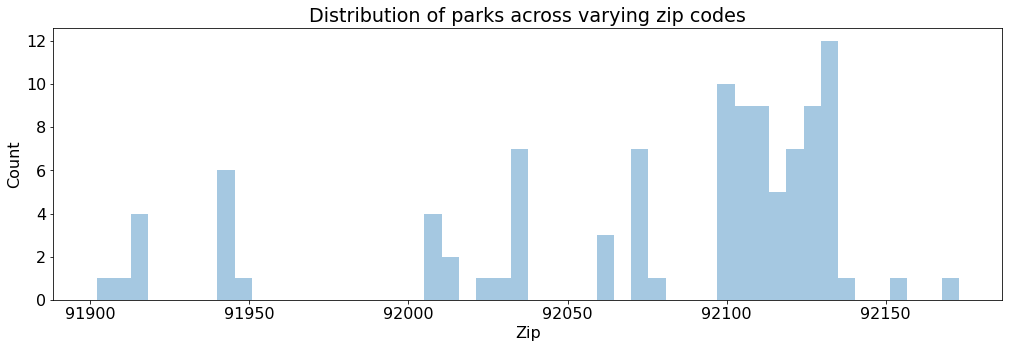

In [11]:
ax1=sns.distplot(parks_zip['Zip'], bins=50,norm_hist = False, kde = False)
ax1.set_ylabel('Count')
ax1.set_title('Distribution of parks across varying zip codes')

Fig 2. This distribution shows that many of the parks are located in a few zip codes, which means that many parks may have similar data tied to zipcodes like median income, minority rate, and poverty rate.

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:3

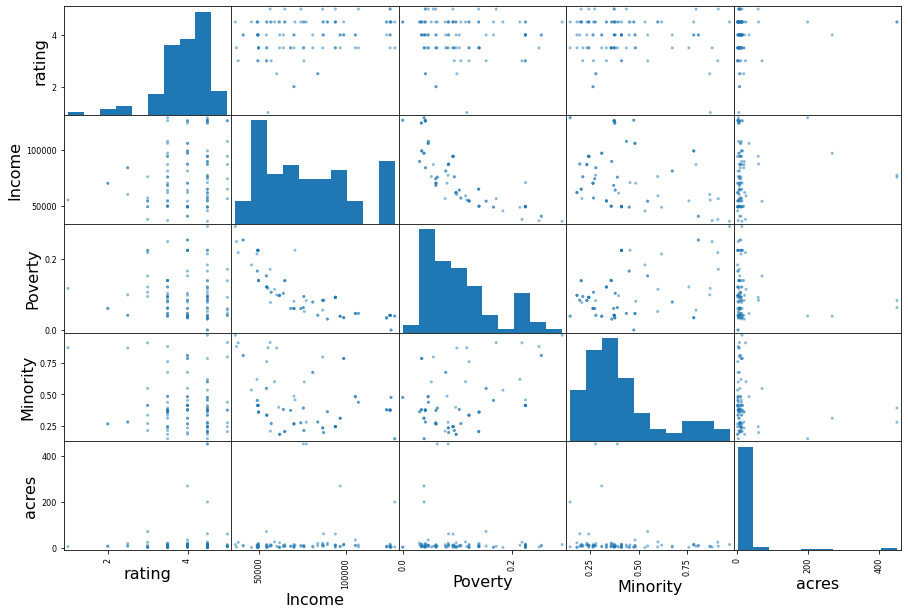

In [12]:
pd.plotting.scatter_matrix(parks_zip[['rating', 'Income', 'Poverty', 'Minority', 'acres']],
                           figsize=(15, 10));

Fig 3. The scatter matrix shows that the data aren't too correlated linearly, and most of the distributions aren't all normal. The only variables that appears to have a distribution that resembles a normal distribution are rating, poverty rate, and minority rate. Even then, these three distributions have skews: negative for rating, and positive for poverty and minority rate. The histogram visualizing the distribution of acres shows that the acres data may need to be transformed using a log transformation. 

Text(0.5, 1.0, 'Distribution of the size in log acres of parks')

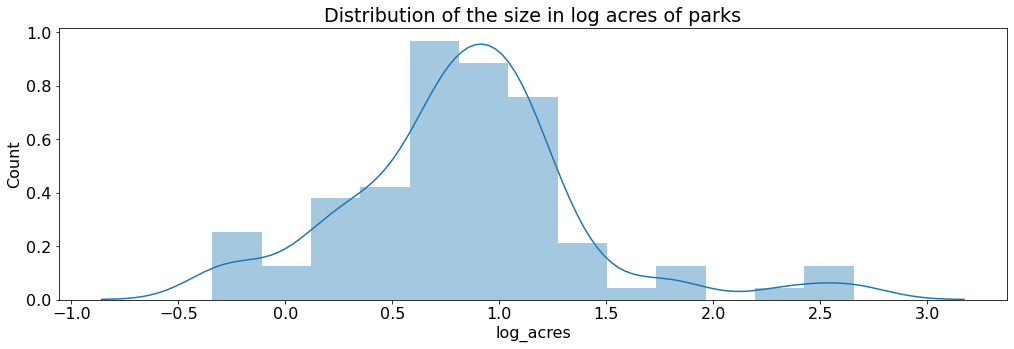

In [13]:
parks_zip=parks_zip.assign(log_acres=parks_zip['acres'].replace(0, 1))
parks_zip['log_acres']=np.log10(parks_zip['acres'])
ax2=sns.distplot(parks_zip['log_acres'], norm_hist = False, kde = True)
ax2.set_ylabel('Count')
ax2.set_title('Distribution of the size in log acres of parks')

Fig 4. The histogram for the log transformed values for acres appears more normally distributed.

In [14]:
parks_zip.corr()

,rating,review_count,Income,Poverty,Minority,acres,log_acres
rating,1.000000,0.131133,0.235374,-0.057321,-0.082722,0.126271,0.116277
review_count,0.131133,1.000000,0.156993,-0.072212,-0.156974,0.416164,0.365403
Income,0.235374,0.156993,1.000000,-0.796873,-0.256107,0.073824,0.107553
Poverty,-0.057321,-0.072212,-0.796873,1.000000,0.340009,-0.113189,-0.119078
Minority,-0.082722,-0.156974,-0.256107,0.340009,1.000000,-0.111050,-0.081944
acres,0.126271,0.416164,0.073824,-0.113189,-0.111050,1.000000,0.682112
log_acres,0.116277,0.365403,0.107553,-0.119078,-0.081944,0.682112,1.000000


Fig 5. Looking at the matrix of correlations, no variable is strongly correlated to yelp rating. There are some weak correlations to review count, median income, acres, and log acres. This suggests that if we perform linear regression using this data, no predictor variable will significantly predict yelp_rating.

To perform linear regression, data should be arranged in multivariate normal probability distributions, not have multicollinearity, not be autocorrelated, and not be homoscedastic. As seen in the scatter plots and 

Text(0.5, 1.0, 'Review Count vs Yelp Rating of parks')

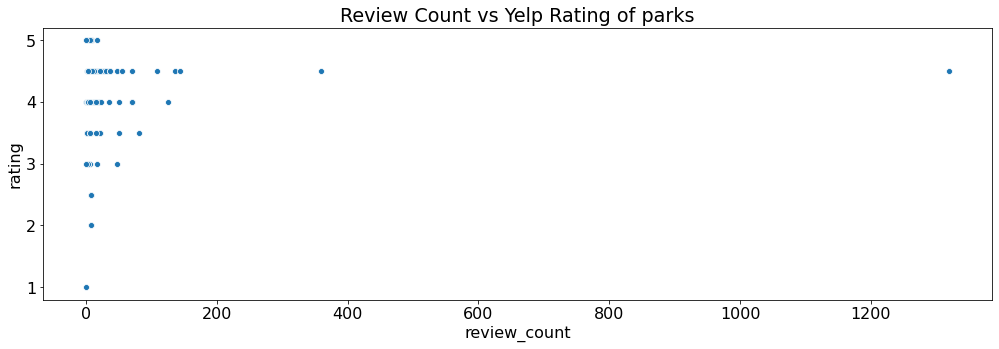

In [15]:
ax3=sns.scatterplot(x='review_count', y='rating', data=parks_zip)
ax3.set_title('Review Count vs Yelp Rating of parks')

Text(0.5, 1.0, 'Poverty rate of zip code of park location vs park Yelp rating')

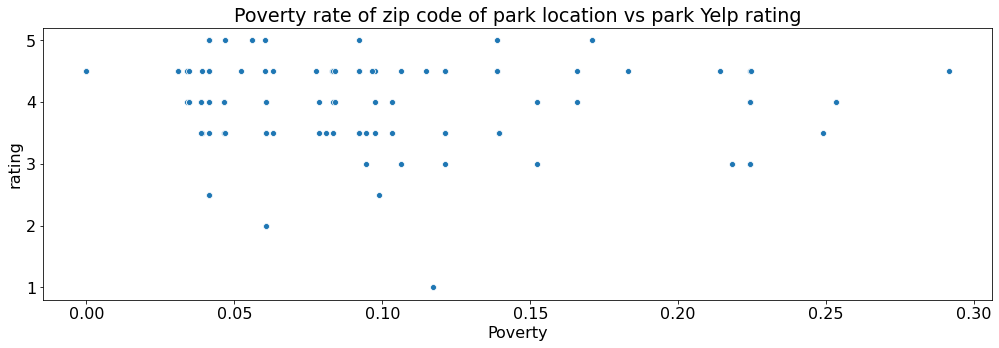

In [16]:
ax4=sns.scatterplot(x='Poverty', y='rating', data=parks_zip)
ax4.set_title('Poverty rate of zip code of park location vs park Yelp rating')

Text(0.5, 1.0, 'Minority rate of zip code of park location vs park rating on yelp')

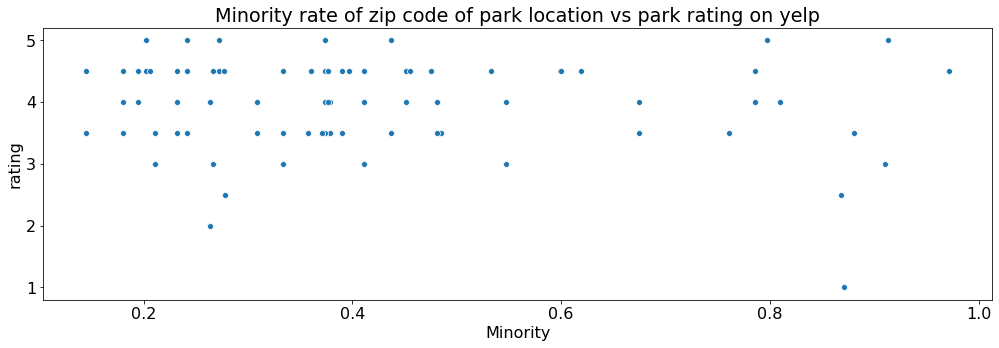

In [17]:
ax5=sns.scatterplot(x='Minority', y='rating', data=parks_zip)
ax5.set_title('Minority rate of zip code of park location vs park rating on yelp')

Text(0.5, 1.0, 'log10 acres of a park vs park rating on yelp')

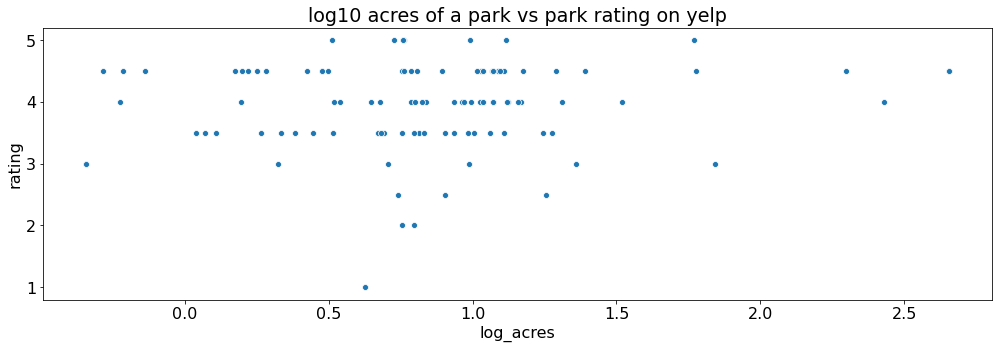

In [18]:
ax6=sns.scatterplot(x='log_acres', y='rating', data=parks_zip)
ax6.set_title('log10 acres of a park vs park rating on yelp')

Fig 6, 7, 8, 9. A set of scatterplot of ratings against the other variables reinforces the information from the figure 5 that there is little linear correlation between the number of reviews and a park's yelp ratings. All scatter plots except for review count vs rating do not suggest that there is heteroscedasticity between rating and the other variables.

## Linear Regression

To find which variable is best for predicting yelp ratings of parks, a multivariate regression model is built.

In [19]:
outcome, predictors = patsy.dmatrices('rating ~ review_count+Poverty+Minority+log_acres', parks_zip)
model=sm.OLS(outcome, predictors)
res=model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                 -0.013
Method:                 Least Squares   F-statistic:                    0.6742
Date:                Wed, 16 Dec 2020   Prob (F-statistic):              0.611
Time:                        09:37:55   Log-Likelihood:                -110.30
No. Observations:                 103   AIC:                             230.6
Df Residuals:                      98   BIC:                             243.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        3.9584      0.218     18.139   

The linear regression model shows that the review count, poverty rate, minority rate, and log acres are not strong or significant predictors of park rating.

# Ethics & Privacy

All datasets used were available online for free use and download. Some datasets were provided, and other datasets are publically available through SANDAG's hosting of census data. There was no information about indivudals that needed to be removed.

There are some ethical concerns with the analysis and data it was performed with. 
A possible bias in the data is a bias in yelp reviews. Yelp reviews may suffer from response bias as people are more likely to respond if they have a highly positive or negative experience, leading to a more polarized distribution of ratings than actual.
Unintentional consequences of analyzing the relationship between socioeconomic/demographic factors and park quality. This data could highlight that there is a relationship between quality and socioeconomic status. It also could have highlighted which areas have parks that are lower quality, making those areas appear less desirable to prospective visitors or residents. Any conclusions from the data must recognize that data is affected by and may reflect inequalities. 

# Conclusion & Discussion

This project intended to see if there was a factor about a park or a factor from the surrounding areas that can be used to determine the quality of the park. Based on this analysis, there is no relationship between socioeconomic factors or the size of a park on the quality of the park. If there was a socioeconomic factor that was a strong predictor of park quality, I would recommend the city focus more on increasing equality across zip codes.

Limitations of this analysis include limitations of the data, and limitations of my understanding of the data. The analysis may have been better if more information about the parks was available and more localized socioeconomic data was available. The only data about park quality available was through yelp ratings. Yelp ratings, besides potentially being biased, may not have as much information for local parks as it does for parks that are geared towards tourists. This analysis only considered parks designated as local, hoping that parks designated as local are the parks that are located in urban or suburban environments usually used for recreational activites. The quality of these parks should be affected by the amenities of the park (playground structures, gymnasiums) and the amount of money spent maintaning the park, something that is directly proportional to the income of the residents of the district.

This analysis did not find a significant relationship between socioeconomic factors and park size on park quality. Having a better understanding of the relationship between the quality of city resources such as parks and socioeconomic status can be useful for tackling inequality.